Directory already exists
Directory already exists
Train on 482 samples, validate on 121 samples
Epoch 1/10
482/482 [==============================] - 2s 4ms/sample - loss: 1.9705 - mape: 164.4187 - val_loss: 1.0715 - val_mape: 207.6837
Epoch 2/10
482/482 [==============================] - 1s 1ms/sample - loss: 1.0336 - mape: 193.4257 - val_loss: 1.0609 - val_mape: 209.5546
Epoch 3/10
482/482 [==============================] - 1s 1ms/sample - loss: 1.0090 - mape: 194.9761 - val_loss: 1.1526 - val_mape: 183.9801
Epoch 4/10
482/482 [==============================] - 1s 1ms/sample - loss: 1.0334 - mape: 185.0910 - val_loss: 1.2051 - val_mape: 274.9219
Epoch 5/10
482/482 [==============================] - 1s 1ms/sample - loss: 0.9857 - mape: 188.6085 - val_loss: 1.1451 - val_mape: 183.0055
Epoch 6/10
482/482 [==============================] - 1s 1ms/sample - loss: 0.9887 - mape: 187.6790 - val_loss: 1.1222 - val_mape: 186.1201
Epoch 7/10
482/482 [==============================] - 1s 1ms/sam

ValueError: setting an array element with a sequence.

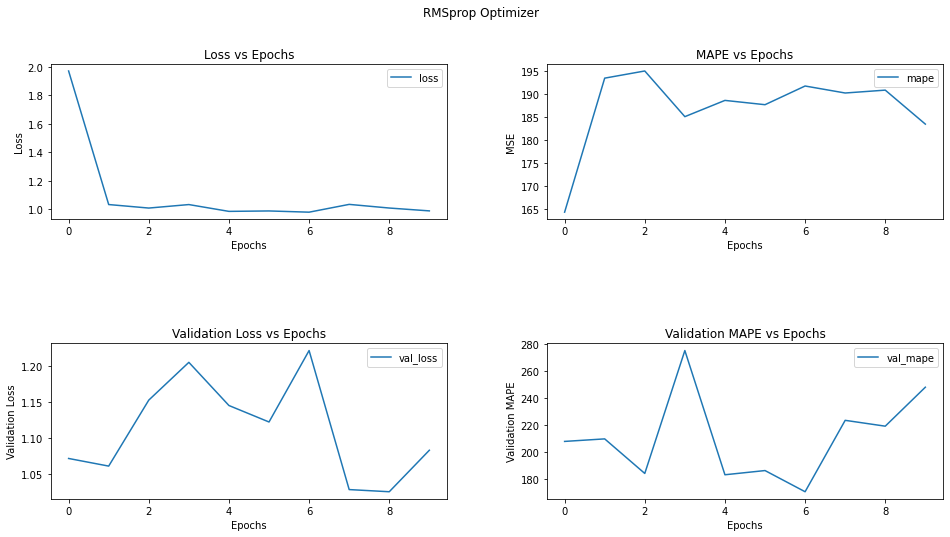

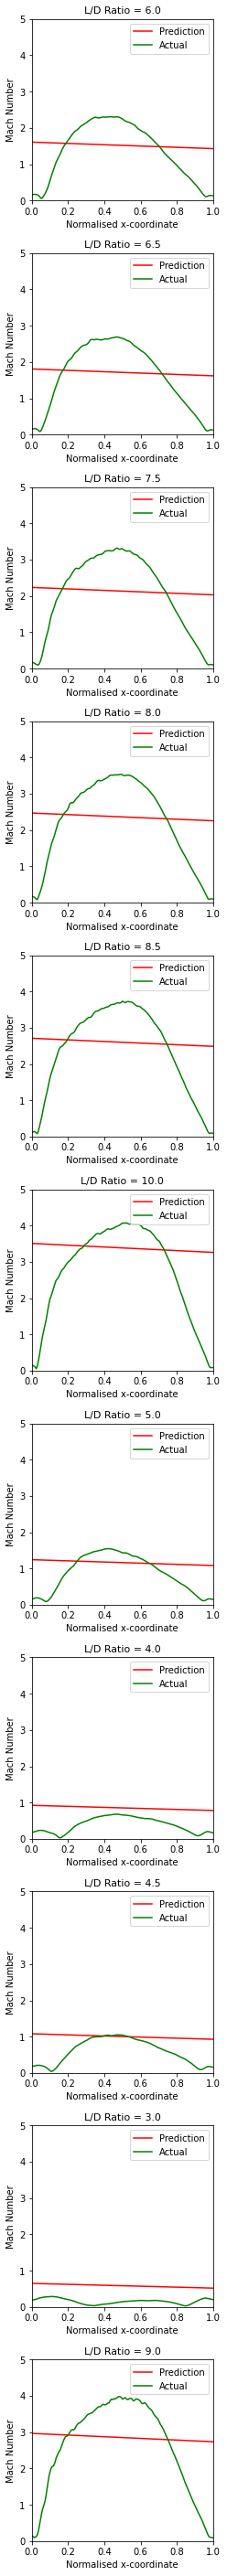

In [27]:
# Importing required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys

def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path
    count = 1



    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return count*0
        else: return count
    else: return -1*count

def get_APE(pred,y_true): # Function to return an array with APE of eaaaah prediction 
    APE = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        APE[i] = abs((pred[i] - y_true[i]) / y_true[i])

    return APE

def get_max_APE(APE): # Function to return the maximum APE with index value
    max_APE = np.zeros(2)

    for k in range(40,160):
        if APE[k] > max_APE[0]:
            max_APE[0] = APE[k]
            max_APE[1] = k
    return max_APE

# Declaring Variables
num_epochs = 2000000


# Filepaths for saving Model and PostProcessed data:
save_post_dir = 'PostProc/SiameseNetwork/OptiStudies/'
save_model_dir = 'SavedModels/SiameseNetwork/OptiStudies/'

# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

# Extracting data into numpy arrays from pandas DataFrames

X = pd.DataFrame(data_dat, columns = ['LD'])
X = X.to_numpy()

X_pred = pd.DataFrame(pred_dat, columns = ['LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()

X_n = pd.DataFrame(data_dat, columns = ['XL'])
X_n = X_n.to_numpy()

X_n_pred = pd.DataFrame(pred_dat, columns = ['XL'])
X_n_pred = X_n_pred.to_numpy()



def get_norm_y(y,c): # Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays
    num = int(y.shape[0] / c)
    max_val = np.zeros(c*num)
    y_norm = np.zeros([num*c])
    for i in range(num):
        max_val[i*c:(i+1)*c] = max(y[i*c:(i+1)*c])
        for j in range(c):
            y_norm[i*c + j] = y[i*c+j]/max_val[i*c+j]
    return y_norm, max_val
    
y_norm, max_y = get_norm_y(y, 201)
y_pred_norm, max_y_pred = get_norm_y(y_pred, 201)

def get_x(x,c): # Returns Input set for training the Max Mach Numbers
    x_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        x_n[i] = x[i]
    
    return x_n

X_max = get_x(X,201)
X_pred_max = get_x(X_pred, 201)

X= np.hstack((X_n,X))
X_pred = np.hstack((X_n_pred,X_pred))

# Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Creating directory to save outputs ####
val_makedir = make_dir('/' + save_post_dir)
if val_makedir == 1:
    print('Directory has been created')
elif val_makedir == -1:
    print('Directory already exists')
else:
    print('Failed to create directory')
    sys.exit(0)

val_makedir = make_dir('/' + save_model_dir)
if val_makedir == 1:
    print('Directory has been created')
elif val_makedir == -1:
    print('Directory already exists')
else:
    print('Failed to create directory')
    sys.exit(0)


def load_optimizers(): # Function to load all optimizers
    Adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.001,
                                            rho=0.95, epsilon=1e-07)
    RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    Adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.01)
    Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    SGD_NM = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
    SGD = tf.keras.optimizers.SGD(learning_rate=0.01)
    Nadam = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

    opti_list = [RMSprop, Adadelta, Adagrad, SGD_NM, SGD, Adam, Nadam]
    opti_name_list = ["RMSprop", "Adadelta", "Adagrad", "SGD_NM", "SGD", "Adam", "Nadam"]
    return opti_list, opti_name_list

opti_list, opti_name_list = load_optimizers()
max_MAPE=np.zeros([len(opti_list), 2*X_pred_max.shape[0]])
for i in range(len(opti_list)):
    opti = opti_list[i]
    opti_name = opti_name_list[i]

    # Define save directory for individual optimizers
    save_model_path = save_model_dir+'model_'+opti_name

    # Architecture for the Siamese Network
    MaxVal_archi = [5,5,5,5,5,5,5,5,5,5,5,5,1]
    IndVal_archi = [20,20,20,20,20,20,20,20,20,20,20,20,1]

    def get_LD(x): # Function to separate L/D Ratio for the Lambda Layer.
        x_new = x[:,1]
        return x_new[:,np.newaxis]

    # Define a function to build a SN
    def build_model(MaxVal_archi, IndVal_archi):

        Input_layer = Input(shape=[2,], name='Input')
        # Lambda layer to separately use it as only L/D ratio input for a fork in Network.
        MaxVal_input = Lambda(get_LD, name='MaxVal_input', output_shape=(1,))(Input_layer)
    	# Defining the MaxVal fork of SN    
        MaxVal_layer = []
        for i,node in enumerate(MaxVal_archi):
            if i==0: # First layer in MaxVal fork
                MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_input))
            elif i==len(MaxVal_archi)-1: # Last layer in MaxVal fork. *Activation must be linear*
                MaxVal_layer.append(Dense(node, name='MaxVal_Final_layer', activation='linear')(MaxVal_layer[i-1]))
            else: # For intermediate layers
                MaxVal_layer.append(Dense(node, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_layer[i-1]))
        # Defining the IndVal fork of Neural Network
        IndVal_layer = []
        for i, node in enumerate(IndVal_archi):
            if i==0: # First layer in MaxVal fork
                IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(Input_layer))
            elif i==len(IndVal_archi)-1: # Last layer in MaxVal fork. *Activation must be linear*
                IndVal_layer.append(Dense(node, name='IndVal_Final_layer', activation='linear')(IndVal_layer[i-1])) 
            else:# For intermediate layers
                IndVal_layer.append(Dense(node, name='IndVal_layer%d' %(i+1), activation='relu')(IndVal_layer[i-1]))
    	# Multiply both layers to get final output.            
        Multiplication_layer = Multiply(name='Multiplication_layer')([IndVal_layer[len(IndVal_archi)-1], MaxVal_layer[len(MaxVal_archi)-1]])
        # Building the model with all connections
        model = Model(inputs= [Input_layer], outputs= [Multiplication_layer])
        return model
    # Calling the model
    model = build_model(MaxVal_archi,IndVal_archi)
    # A visual flowchart of the model.
    keras.utils.plot_model(model, "Architecture_SN.png", show_shapes=True)

    # Define early stopping callback
    early_stopping_callback = EarlyStopping(monitor='val_mape', 
                                            patience=500,
                                            min_delta= 1e-4,
                                            restore_best_weights=True,
                                            mode='auto',
                                            verbose=True)
    # Compile the model
    model.compile(loss='mse', optimizer='Adam', metrics=['mape'])
    # Train the model
    history = model.fit(X_train,
                        y_train_comb,
                        batch_size = 5,
                        epochs=10,
                        verbose=True,
                        validation_data=(X_test, y_test_comb),
                        callbacks=[early_stopping_callback])
    # Save the best version of the model.
    model.save('temp_models/SiameseModel3')
    # write  model training metrics to a dataframe
    model_data = pd.DataFrame(history.history)
    model_data.head()
    # Subplot for Plotting training metrics
    nrows = 2
    ncols = 2 
    # Initialise the plot
    fig1 = plt.figure()
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(16,8)
    # Plot loss in [0,0]
    loss_plot=model_data.plot(y="loss", title ="Loss vs Epochs", ax=axes[0,0])
    loss_plot.set(xlabel="Epochs", ylabel="Loss")
    # Plot MSE in [0,1]
    mse_plot=model_data.plot(y="mape", title ="MAPE vs Epochs", ax=axes[0,1])
    mse_plot.set(xlabel="Epochs", ylabel="MSE")
    # Plot val_loss in [1,0]
    val_loss_plot=model_data.plot(y="val_loss", title ="Validation Loss vs Epochs", ax= axes[1,0])
    val_loss_plot.set(xlabel="Epochs", ylabel="Validation Loss")
    # Plot val_mse in [1,1]
    val_mse_plot=model_data.plot(y="val_mape", title ="Validation MAPE vs Epochs", ax= axes[1,1])
    val_mse_plot.set(xlabel="Epochs", ylabel="Validation MAPE")
    # Subplot properties
    plt.suptitle("%s Optimizer " %(opti_name)) # Subplot title
    plt.subplots_adjust(wspace=0.25, hspace=0.8) # Spacing details
    plt.savefig(save_post_dir + '%s_stats.png' %(opti_name), dpi=500)
    # plt.show(fig1)
    plt.close(fig1)

    # predictions of trained model
    pred=model.predict(X_pred)

    # Subplot of predictions
    nrows=int(X_pred.shape[0]/201)
    fig3 = plt.figure()
    fig, axes = plt.subplots(nrows)
    fig.set_size_inches(6,39)
    for j in range(nrows):
        axes[j].plot(X_n_pred[:201],
                      pred[j*201:(j+1)*201],
                      'r',
                      label='Prediction')
        axes[j].plot(X_n_pred[j*201:(j+1)*201],
                     y_pred[j*201:(j+1)*201],
                     'g', label='Actual')
        axes[j].set(xlabel="Normalised x-coordinate",
                    ylabel="Mach Number")
        axes[j].set_title('L/D Ratio = %.1f' %(X_pred_max[201*j]),
                          fontsize=11)
        axes[j].legend(loc="upper right")
        axes[j].set_xlim((0,1))
        axes[j].set_ylim((0,5))
        axes[j].set_aspect(0.2)

    fig = plt.gcf()
    plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
    plt.savefig(save_post_dir + 'cumilative_ind_%s_predictions.png' %(opti_name), dpi=500)
    # plt.show(fig3)
    plt.close(fig3)

    # Get Max APE for each opti
    pred_APE = get_APE(pred, y_pred)
    for j in range(X_pred_max.shape[0]):
        max_MAPE[i,2*j] = get_max_APE(pred_APE[j*201:(j+1)*201])*100
        max_MAPE[i,2*j+1] = get_max_APE(pred_APE[j*201:(j+1)*201])[1]


    

    del(model)

column_df = []
for i in range(X_pred_max.shape[0]):
    if i%2==0:
        column_df.append(str(X_pred_max[i])+' MAPE')
    else:
        column_df.append(str(X_pred_max[i])+' index')
MAPE_df = pd.DataFrame(max_MAPE_n, 
                       index=opti_name_list, 
                       columns=column_df)

MAPE_df.to_csv(save_post_dir + 'Cumilative_max_MAPE.csv', index=True, header=True, sep=',')



In [31]:
def get_max_APE(APE): # Function to return the maximum APE with index value
    max_APE = np.zeros(2)
    print(APE.shape)

    for k in range(40,160):
        if APE[k] > max_APE[0]:
            max_APE[0] = APE[k]
            max_APE[1] = k
    return max_APE

In [35]:
# Get Max APE for each opti
max_MAPE=np.zeros([len(opti_list), 2*X_pred_max.shape[0]])
pred_APE = get_APE(pred, y_pred)
print(X_pred_max.shape)
for j in range(int(X_pred_max.shape[0]/201)):
    print(j)
    max_APE_temp = get_max_APE(pred_APE[j*201:(j+1)*201])
    max_MAPE[i,2*j] = max_APE_temp[0]*100
    max_MAPE[i,2*j+1] = max_APE_temp[1]


(2211,)
0
(201,)
1
(201,)
2
(201,)
3
(201,)
4
(201,)
5
(201,)
6
(201,)
7
(201,)
8
(201,)
9
(201,)
10
(201,)


In [37]:
print(max_MAPE)

[[ 48.1928194  159.          41.97051779 ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [14]:
get_max_APE(pred_APE[j*201:(j+1)*201])*100

array([  39.76786333, 9600.        ])

In [21]:
for i in range(40,160): print(i)

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
